# Настройка среды

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

import torch
import numpy
import pandas
import json
from torch.profiler import profile, ProfilerActivity
from scipy.interpolate import interp1d

from belashovplot import TiledPlot
from parameters import FigureWidthHeight, FontLibrary

device = torch.device(0)

In [14]:
class MemoryRecorder:
    def __init__(self):
        self.profier = None
    def __enter__(self):
        self.profier = profile(
            activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA], 
            record_shapes=True, 
            profile_memory=True, 
            with_stack=False, 
            with_flops=True, 
            with_modules=True, 
            )
        self.profier.start()
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.profier is not None:
            self.profier.stop()
            self.profier.export_chrome_trace("logs/trace.json")
            self.profier = None
        torch.cuda.empty_cache()
        
        with open("logs/trace.json", "r") as f:
            trace_data = json.load(f)
            events = sorted(trace_data['traceEvents'], key=lambda x: x['ts'])
        memory = [event for event in events if event['name'] == '[memory]']
        cuda_memory = [event for event in memory if event['args']['Device Type'] == 1]

        times = []
        ticks = []
        ticks_times =[]
        ticks_memory_reserved = []
        ticks_memory_allocated = []
        memory_reserved = [0]
        memory_allocated = [0]
        trigger = False
        trigger_counter = 0
        for event in events:
            if event['name'] == '[memory]' and event['args']['Device Type'] == 1:
                memory_reserved.append(event['args']['Total Reserved'])
                memory_allocated.append(event['args']['Total Allocated'])
            else:
                memory_reserved.append(memory_reserved[-1])
                memory_allocated.append(memory_allocated[-1])
            times.append(event['ts'])
            if event['name'].startswith('aten::') or event['name'] == "[memory]" or trigger:
                trigger = True
                if event['name'].startswith('aten::'):
                    trigger_counter = 0
                    ticks.append(event['name'][len('aten::'):])
                else:
                    if len(event['name']) <= 12:
                        ticks.append(event['name'])
                    else:
                        ticks.append(event['name'][:6] + '...' + event['name'][-6:])
                ticks_times.append(event['ts'])
                ticks_memory_reserved.append(memory_reserved[-1])
                ticks_memory_allocated.append(memory_allocated[-1])
            trigger_counter += 1
            if trigger_counter >= 6:
                trigger = False
        memory_allocated = memory_allocated[1:]
        memory_reserved = memory_reserved[1:]
        times = numpy.array(times)
        memory_reserved = numpy.array(memory_reserved)
        memory_allocated = numpy.array(memory_allocated)
        max_memory = numpy.max(memory_allocated)

        plot = TiledPlot(*FigureWidthHeight)
        plot.FontLibrary = FontLibrary
        plot.width_to_height(2.0)
        axes = plot.axes.add()
        axes.xaxis.set_ticks(numpy.arange(len(ticks)), ticks, rotation=90, fontsize=9)
        axes.plot(ticks_memory_allocated, label='allocated', linewidth=1.5, color='maroon')
        axes.plot(ticks_memory_reserved, label='reserved', linestyle='--', alpha=0.5)
        axes.axhline(max_memory, linestyle='-.', alpha=0.5, label=f"max allocated {round(max_memory/1024/1024,2)}MB")
        axes.legend()
        axes.grid(True)
        def formatter(x, id):
            return f"{round(x/1024/1024,2)}MB"
        axes.yaxis.set_major_formatter(formatter)
        plot.description.bottom(f"Total time: {(times[-1]-times[0])*1.0E-3}us")
        plot.show()

# Broadcast

In [15]:
B = 64
C = 1
M = 50
N = 1024

STAGE:2024-07-15 13:26:14 1811059:1811059 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-15 13:26:14 1811059:1811059 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-15 13:26:14 1811059:1811059 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


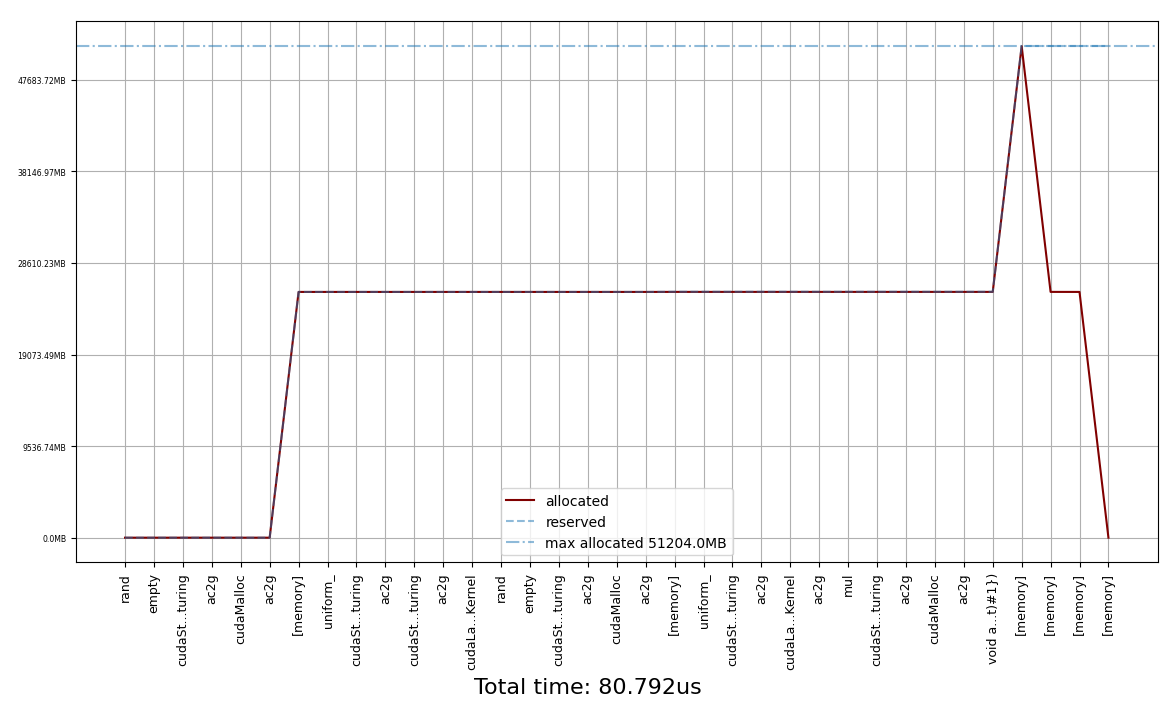

STAGE:2024-07-15 13:26:14 1811059:1811059 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-15 13:26:15 1811059:1811059 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-15 13:26:15 1811059:1811059 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


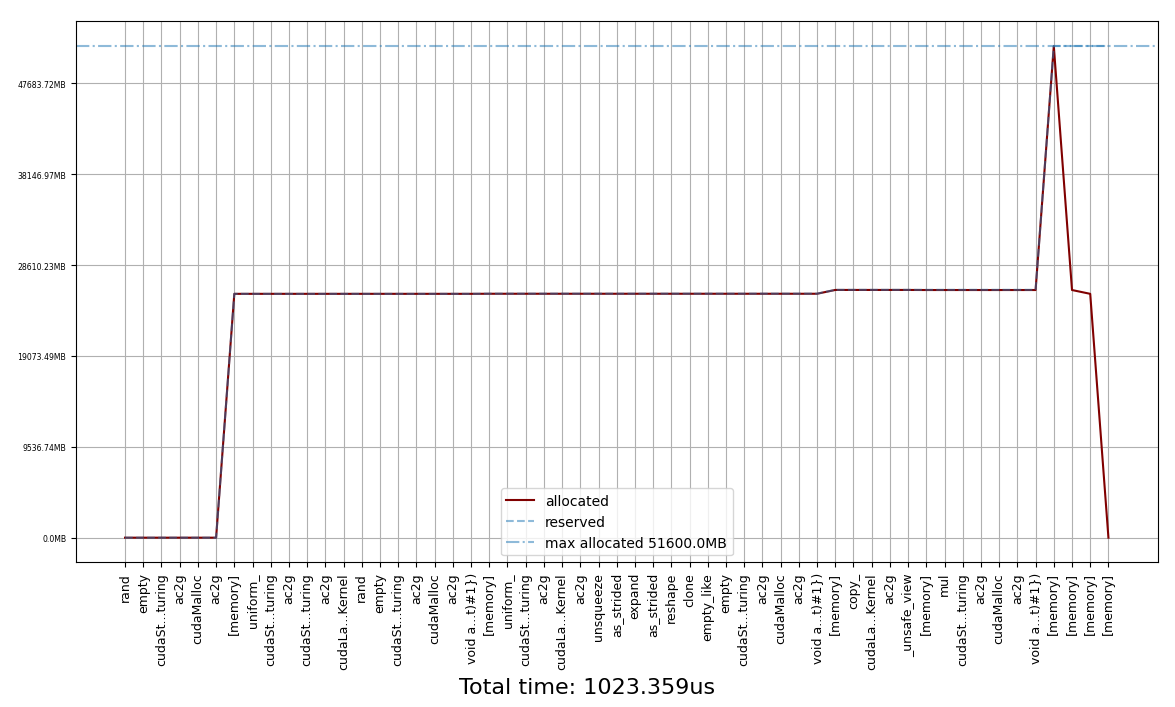

STAGE:2024-07-15 13:26:16 1811059:1811059 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-15 13:26:17 1811059:1811059 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-15 13:26:17 1811059:1811059 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


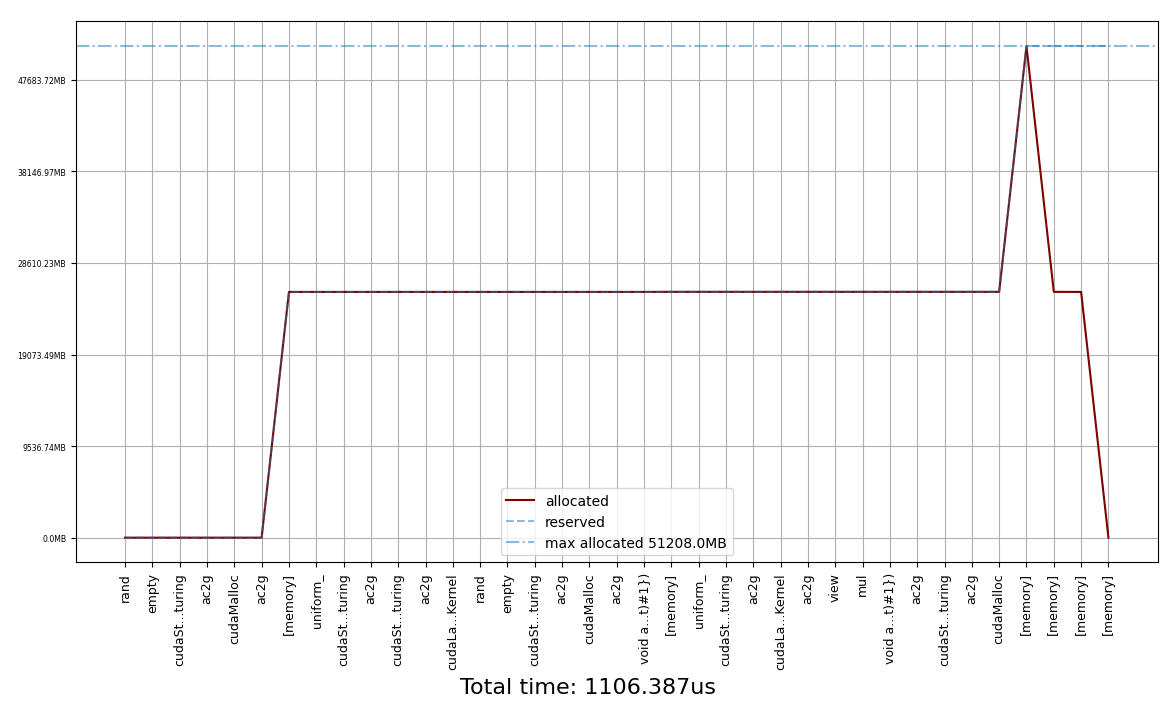

STAGE:2024-07-15 13:26:17 1811059:1811059 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-15 13:26:18 1811059:1811059 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-15 13:26:18 1811059:1811059 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


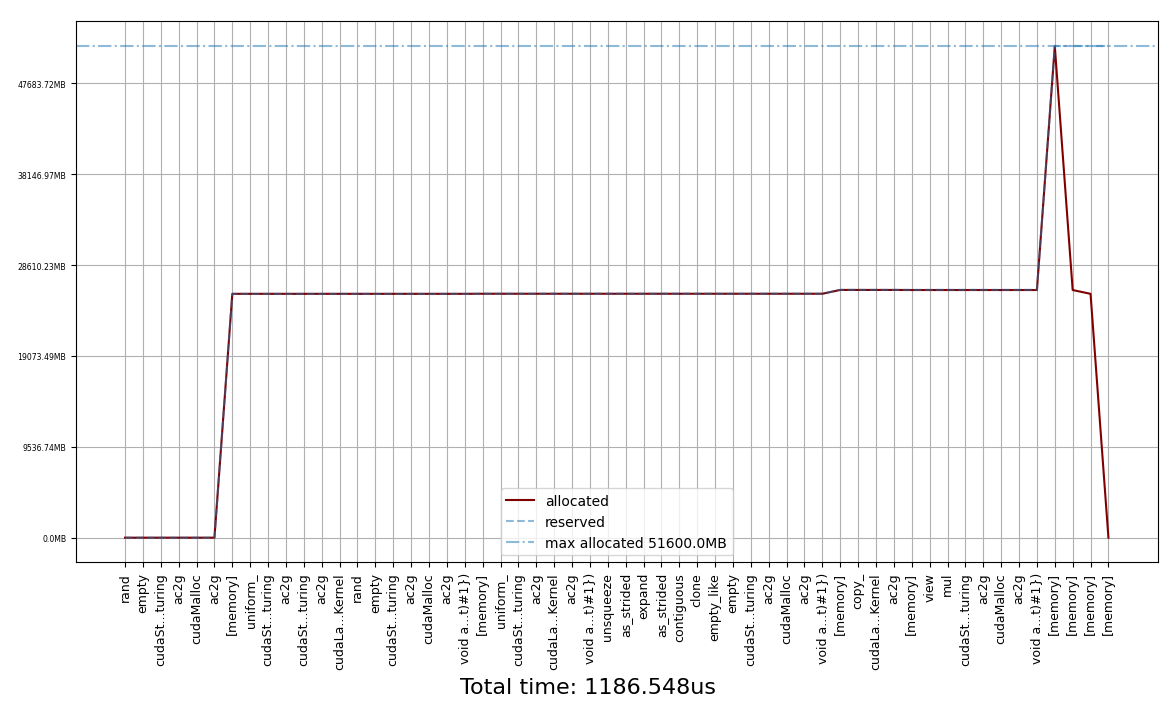

In [18]:
C = 1
M = 100
with MemoryRecorder():
    data = torch.rand((B,C*M,N,N), device=device, dtype=torch.float32).contiguous()
    kernel = torch.rand((C,N,N), device=device, dtype=torch.float32).contiguous()
    result = kernel * data
    del data
    del kernel
    del result

C = 2
M = 50
with MemoryRecorder():
    data = torch.rand((B,C*M,N,N), device=device, dtype=torch.float32).contiguous()
    kernel = torch.rand((C,N,N), device=device, dtype=torch.float32).contiguous()
    kernel = kernel.unsqueeze(0)
    kernel = kernel.expand(M,C,N,N)
    kernel = kernel.reshape(M*C,N,N)
    result = kernel * data
    del data
    del kernel
    del result

C = 2
M = 50
with MemoryRecorder():
    data = torch.rand((B,C*M,N,N), device=device, dtype=torch.float32).contiguous()
    kernel = torch.rand((C,N,N), device=device, dtype=torch.float32).contiguous()
    data = data.view(B,M,C,N,N)
    result = kernel * data
    del data
    del kernel
    del result

C = 2
M = 50
with MemoryRecorder():
    data = torch.rand((B,C*M,N,N), device=device, dtype=torch.float32).contiguous()
    kernel = torch.rand((C,N,N), device=device, dtype=torch.float32).contiguous()
    kernel = kernel.unsqueeze(0)
    kernel = kernel.expand(M,C,N,N).contiguous()
    kernel = kernel.view(M*C,N,N)
    result = kernel * data
    del data
    del kernel
    del result